In [43]:
# MREyeQC_PA: Model Training and Evaluation Notebook

# ## 1. Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC 
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report, balanced_accuracy_score
)
import joblib 
import os

# Optional: If you have utility functions in your project
from fetmrqc_sr.qc_evaluation import load_dataset, preprocess 
from utils import pick_scaler, add_group, load_and_format_data

plt.style.use('ggplot')
sns.set_palette("viridis")

print("Libraries imported successfully.")

Libraries imported successfully.


In [44]:
import skimage
print(skimage.__version__)

0.24.0


In [45]:
DATA_CSV_PATH = "/Users/cyriltelley/Desktop/MSE/Second_semester/PA-MReye/Codes/MREyeQC_PA/data/IQA.csv"

SAMPLE_ID_COLUMN = "name" 
RATING_TEXT_COLUMN = "rating_text"

POSITIVE_CLASS_NAME_BINARY = "accept" 
NEGATIVE_CLASS_NAME_BINARY = "reject"

EXCLUDED_COLUMNS_FROM_FEATURES = [
    "name",
    "sub",
    "ses",
    "run",
    "rating",
    "rating_text",
    "rating1",
    "rating1_text",
    "rating2",
    "rating2_text",
    "blur",
    "blur_text",
    "noise",
    "noise_text",
    "motion",
    "motion_text",
    "bgair,bgair_text",
    "artifacts",
    "nselected",
    "selected_slices",
    "comments,time_sec",
    "timestamp",
    "dataset",
    "im",
    "mask",
    "ratings_json",
    "seg",
    "seg_proba"

]

MODEL_CHOICE = 'RandomForest' 
#MODEL_CHOICE = 'SVM'
#MODEL_CHOICE = 'LogisticRegression'
TEST_SET_SIZE = 0.25
RANDOM_STATE = 42


MODEL_OUTPUT_DIR = "./trained_models_MREyeQC_PA"
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)

print("Configuration set.")
print(f"Data will be loaded from: {DATA_CSV_PATH}")
print(f"Sample ID column: {SAMPLE_ID_COLUMN}")
print(f"Text rating column (target source): {RATING_TEXT_COLUMN}")

Configuration set.
Data will be loaded from: /Users/cyriltelley/Desktop/MSE/Second_semester/PA-MReye/Codes/MREyeQC_PA/data/IQA.csv
Sample ID column: name
Text rating column (target source): rating_text


In [46]:
# ## 3. Load Data

df_data = pd.DataFrame()

try:
    df_data = pd.read_csv(DATA_CSV_PATH)
    print(f"Data loaded successfully from: {DATA_CSV_PATH}")
    print(f"DataFrame shape: {df_data.shape}")
    print(f"DataFrame columns: {df_data.columns.tolist()}")
    print("\nDataFrame head:\n", df_data.head())
    required_cols_present = True
    if SAMPLE_ID_COLUMN not in df_data.columns:
        print(f"ERROR: Sample ID column '{SAMPLE_ID_COLUMN}' not found in {DATA_CSV_PATH}.")
        required_cols_present = False
    if RATING_TEXT_COLUMN not in df_data.columns:
        print(f"ERROR: Rating text column '{RATING_TEXT_COLUMN}' not found in {DATA_CSV_PATH}.")
        required_cols_present = False
    
    if not required_cols_present:
        df_data = pd.DataFrame() 

except FileNotFoundError:
    print(f"ERROR: Data file not found at {DATA_CSV_PATH}. Please check the path.")
except Exception as e:
    print(f"An error occurred while loading data: {e}")


if not df_data.empty:
    print(f"\nMissing values in rating text column '{RATING_TEXT_COLUMN}' before drop: {df_data[RATING_TEXT_COLUMN].isnull().sum()}")
    df_data.dropna(subset=[RATING_TEXT_COLUMN], inplace=True)
    print(f"Missing values in rating text column '{RATING_TEXT_COLUMN}' after drop: {df_data[RATING_TEXT_COLUMN].isnull().sum()}")
    print(f"Data shape after dropping NaNs in target source: {df_data.shape}")
else:
    print("\nData loading failed or required columns missing. Further processing skipped.")

Data loaded successfully from: /Users/cyriltelley/Desktop/MSE/Second_semester/PA-MReye/Codes/MREyeQC_PA/data/IQA.csv
DataFrame shape: (83, 264)
DataFrame columns: ['name', 'sub', 'ses', 'run', 'rating', 'rating_text', 'rating1', 'rating1_text', 'rating2', 'rating2_text', 'blur', 'blur_text', 'noise', 'noise_text', 'motion', 'motion_text', 'bgair', 'bgair_text', 'artifacts', 'nselected', 'selected_slices', 'comments', 'time_sec', 'timestamp', 'dataset', 'im', 'mask', 'ratings_json', 'seg', 'seg_proba', 'centroid', 'centroid_nan', 'centroid_full', 'centroid_full_nan', 'rank_error', 'rank_error_nan', 'rank_error_relative', 'rank_error_relative_nan', 'mask_volume', 'mask_volume_nan', 'ncc_window', 'ncc_window_nan', 'ncc_median', 'ncc_median_nan', 'joint_entropy_window', 'joint_entropy_window_nan', 'joint_entropy_median', 'joint_entropy_median_nan', 'mi_window', 'mi_window_nan', 'mi_median', 'mi_median_nan', 'nmi_window', 'nmi_window_nan', 'nmi_median', 'nmi_median_nan', 'psnr_window', 'psn


--- Data Exploration ---
Data types of all columns:
 name                          object
sub                            int64
ses                          float64
run                          float64
rating                       float64
                              ...   
seg_topology_mask_ec_nan        bool
seg_globe_sphericity         float64
seg_globe_sphericity_nan        bool
seg_lens_aspect_ratio        float64
seg_lens_aspect_ratio_nan       bool
Length: 264, dtype: object

Original target text rating distribution ('rating_text'):
 rating_text
acceptable    0.421687
poor          0.301205
excellent     0.216867
exclude       0.060241
Name: proportion, dtype: float64


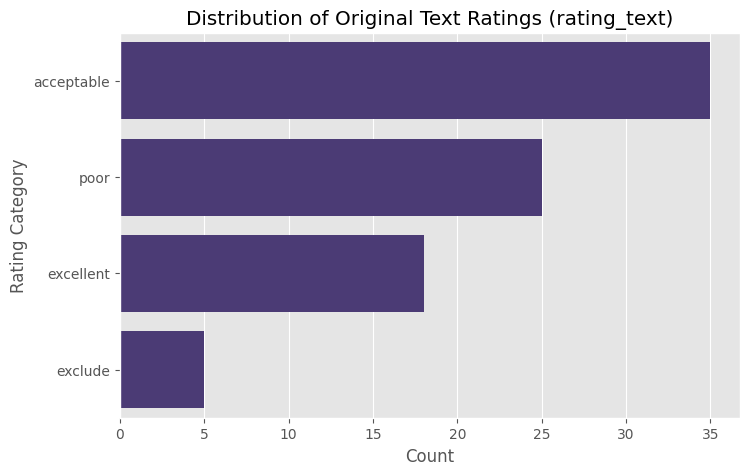


Unique original text ratings found: ['acceptable' 'poor' 'excellent' 'exclude']

Binarized target variable distribution (0=reject, 1=accept):
 binary_target
1    0.939759
0    0.060241
Name: proportion, dtype: float64


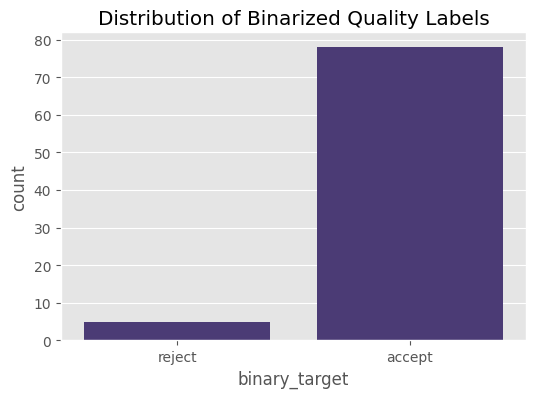


Identified 119 numeric features for training.

NaN values in features before filling: 0
NaN values in features after filling with 0: 0

Train set shape: X_train=(62, 119), y_train=(62,)
Test set shape: X_test=(21, 119), y_test=(21,)

Preprocessing complete.


In [47]:
# Cell 4: Data Exploration and Preprocessing

# ## 4. Data Exploration and Preprocessing

if not df_data.empty:
    print("\n--- Data Exploration ---")
    print("Data types of all columns:\n", df_data.dtypes)
    print(f"\nOriginal target text rating distribution ('{RATING_TEXT_COLUMN}'):\n", df_data[RATING_TEXT_COLUMN].value_counts(normalize=True))

    plt.figure(figsize=(8, 5))
    sns.countplot(y=RATING_TEXT_COLUMN, data=df_data, order=df_data[RATING_TEXT_COLUMN].value_counts().index)
    plt.title(f'Distribution of Original Text Ratings ({RATING_TEXT_COLUMN})')
    plt.xlabel("Count")
    plt.ylabel("Rating Category")
    plt.show()

    y_original_text = df_data[RATING_TEXT_COLUMN].copy()
    print(f"\nUnique original text ratings found: {y_original_text.unique()}")

    def binarize_ratings(rating_text_value):
        if rating_text_value == "exclude":
            return 0
        else:
            return 1

    y_binary = y_original_text.apply(binarize_ratings)
    df_data['binary_target'] = y_binary

    print(f"\nBinarized target variable distribution (0={NEGATIVE_CLASS_NAME_BINARY}, 1={POSITIVE_CLASS_NAME_BINARY}):\n {df_data['binary_target'].value_counts(normalize=True)}")

    plt.figure(figsize=(6, 4))
    sns.countplot(x='binary_target', data=df_data)
    plt.title('Distribution of Binarized Quality Labels')
    plt.xticks([0, 1], [NEGATIVE_CLASS_NAME_BINARY, POSITIVE_CLASS_NAME_BINARY])
    plt.show()

    all_columns = df_data.columns.tolist()
    cols_to_remove_for_X = EXCLUDED_COLUMNS_FROM_FEATURES + ['binary_target']
    if RATING_TEXT_COLUMN not in cols_to_remove_for_X:
        cols_to_remove_for_X.append(RATING_TEXT_COLUMN)

    potential_feature_names = [col for col in all_columns if col not in cols_to_remove_for_X]
    X = df_data[potential_feature_names].select_dtypes(include=np.number).copy()
    numeric_features_identified = X.columns.tolist()

    print(f"\nIdentified {len(numeric_features_identified)} numeric features for training.")

    y = df_data['binary_target'].copy()

    print(f"\nNaN values in features before filling: {X.isnull().sum().sum()}")
    X.fillna(0, inplace=True)
    print(f"NaN values in features after filling with 0: {X.isnull().sum().sum()}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SET_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    print(f"\nTrain set shape: X_train={X_train.shape}, y_train={y_train.shape}")
    print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numeric_features_identified)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numeric_features_identified)

    print("\nPreprocessing complete.")
else:
    print("\nSkipping preprocessing as data is not loaded/available.")


In [48]:
## 5. Model Training

if 'X_train_scaled' in locals() and 'y_train' in locals(): # Check if training data exists
    print(f"\n--- Model Training ({MODEL_CHOICE}) ---")

    if MODEL_CHOICE == 'RandomForest':
        model = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    elif MODEL_CHOICE == 'SVM':
        model = SVC(probability=True, random_state=RANDOM_STATE, class_weight='balanced')
        param_grid = {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto', 0.01],
            'kernel': ['rbf']
        }
    else:
        if MODEL_CHOICE == 'LogisticRegression': 
            from sklearn.linear_model import LogisticRegression
            model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', solver='liblinear')
            param_grid = {'C': [0.1, 1, 10]}
        else:
            raise ValueError(f"Unsupported MODEL_CHOICE: {MODEL_CHOICE}. Add its definition and param_grid.")


    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    print("\nStarting GridSearchCV for hyperparameter tuning...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_strategy, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_scaled, y_train)

    print(f"\nBest parameters found by GridSearchCV: {grid_search.best_params_}")
    print(f"Best ROC AUC score on CV: {grid_search.best_score_:.4f}")

    best_model = grid_search.best_estimator_
    
    print("\nModel training complete.")
else:
    print("\nSkipping model training as training data is not available.")


--- Model Training (RandomForest) ---

Starting GridSearchCV for hyperparameter tuning...
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/Users/cyriltelley/miniconda3/envs/mreyeqc_env/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/cyriltelley/miniconda3/envs/mreyeqc_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cyriltelley/miniconda3/envs/mreyeqc_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/cyriltelley/miniconda3/envs/mreyeqc_env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/cyriltelley/miniconda3/envs/mreyeqc_env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 384, in _score
    return self._sig


Best parameters found by GridSearchCV: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best ROC AUC score on CV: nan

Model training complete.


/Users/cyriltelley/miniconda3/envs/mreyeqc_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/Users/cyriltelley/miniconda3/envs/mreyeqc_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:968: RuntimeWarning: invalid value encountered in cast
  results["rank_%s" % key_name] = np.asarray(


Balanced Accuracy: 0.5000

Test Set Evaluation Metrics (Positive class is '1' representing 'accept'):
Accuracy:  0.9524
Precision: 0.9524
Recall:    1.0000
F1-score:  0.9756
ROC AUC:   0.9000

Classification Report:
               precision    recall  f1-score   support

      reject       0.00      0.00      0.00         1
      accept       0.95      1.00      0.98        20

    accuracy                           0.95        21
   macro avg       0.48      0.50      0.49        21
weighted avg       0.91      0.95      0.93        21



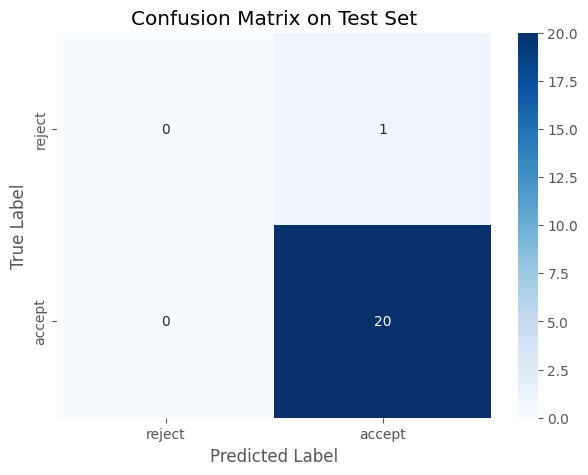

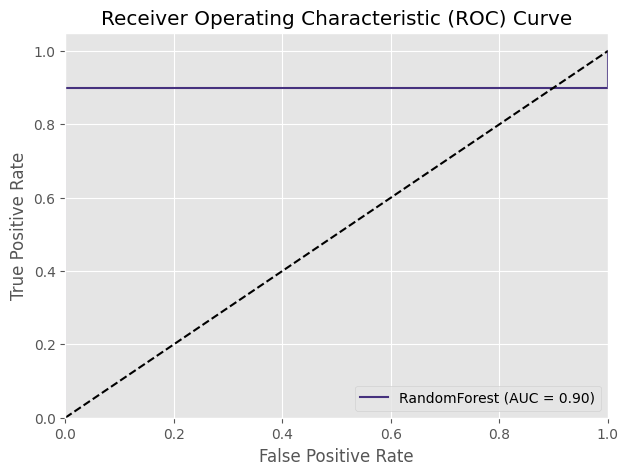

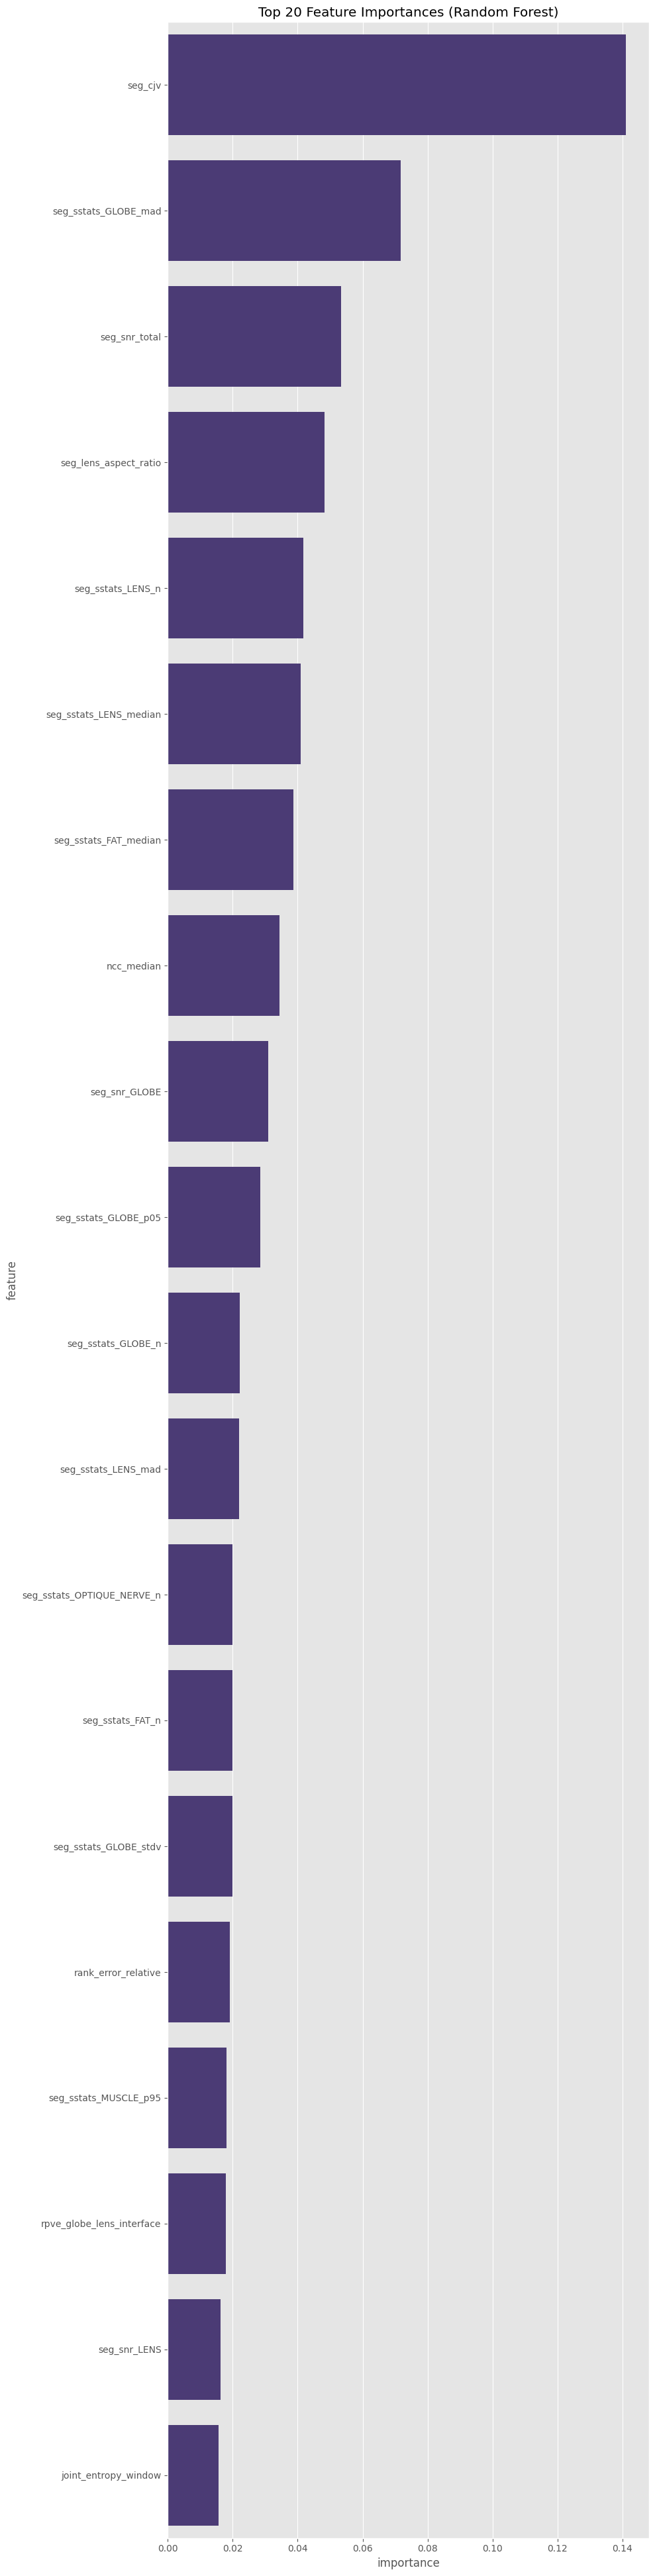


Top 10 Feature Importances:
                     feature  importance
92                  seg_cjv    0.141120
54     seg_sstats_GLOBE_mad    0.071755
90            seg_snr_total    0.053303
118   seg_lens_aspect_ratio    0.048184
47        seg_sstats_LENS_n    0.041806
41   seg_sstats_LENS_median    0.040971
65    seg_sstats_FAT_median    0.038658
8                ncc_median    0.034318
86            seg_snr_GLOBE    0.030936
51     seg_sstats_GLOBE_p05    0.028566


In [49]:
## 6. Model Prediction and Evaluation

if 'best_model' in locals() and 'X_test_scaled' in locals() and 'y_test' in locals():
    y_pred_test = best_model.predict(X_test_scaled)
    balanced_acc = balanced_accuracy_score(y_test, y_pred_test)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    y_pred_proba_test = best_model.predict_proba(X_test_scaled)[:, 1]

    accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, pos_label=1, zero_division=0)
    recall = recall_score(y_test, y_pred_test, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred_test, pos_label=1, zero_division=0)
    
    try:
        roc_auc = roc_auc_score(y_test, y_pred_proba_test)
    except ValueError as e:
        print(f"ROC AUC calculation error: {e}. Check if y_test contains only one class after split.")
        roc_auc = float('nan')


    print(f"\nTest Set Evaluation Metrics (Positive class is '1' representing '{POSITIVE_CLASS_NAME_BINARY}'):")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")

    report_target_names = [NEGATIVE_CLASS_NAME_BINARY, POSITIVE_CLASS_NAME_BINARY]
    print("\nClassification Report:\n", classification_report(y_test, y_pred_test, target_names=report_target_names, zero_division=0))

    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=report_target_names, yticklabels=report_target_names)
    plt.title('Confusion Matrix on Test Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    if not np.isnan(roc_auc):
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test, pos_label=1)
        plt.figure(figsize=(7, 5))
        plt.plot(fpr, tpr, label=f'{MODEL_CHOICE} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    if MODEL_CHOICE == 'RandomForest' and hasattr(best_model, 'feature_importances_') and 'numeric_features_identified' in locals():
        importances = best_model.feature_importances_
        feature_importance_df = pd.DataFrame({'feature': numeric_features_identified, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

        plt.figure(figsize=(10, max(6, len(numeric_features_identified) // 3 if len(numeric_features_identified) > 0 else 6)))
        sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
        plt.title('Top 20 Feature Importances (Random Forest)')
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 Feature Importances:\n", feature_importance_df.head(10))
else:
    print("\nSkipping model evaluation as model was not trained or test data is not available.")

In [50]:
## 7. Saving the Model 

if ('best_model' in locals() and 
    'scaler' in locals() and 
    'numeric_features_identified' in locals() and 
    os.path.exists(MODEL_OUTPUT_DIR)): 

    print("\n--- Saving the Model and Associated Objects ---")
    model_filename = os.path.join(MODEL_OUTPUT_DIR, f"mreyeqc_model_{MODEL_CHOICE.lower()}.joblib")
    scaler_filename = os.path.join(MODEL_OUTPUT_DIR, "mreyeqc_scaler.joblib")
    features_filename = os.path.join(MODEL_OUTPUT_DIR, "mreyeqc_features.json")
    class_names_filename = os.path.join(MODEL_OUTPUT_DIR, "mreyeqc_binary_class_names.json")


    try:
        joblib.dump(best_model, model_filename)
        print(f"Trained model saved to: {model_filename}")
        
        joblib.dump(scaler, scaler_filename)
        print(f"Scaler saved to: {scaler_filename}")
        
        import json
        with open(features_filename, 'w') as f:
            # Save numeric_features_identified from Cell 4
            json.dump(numeric_features_identified, f)
        print(f"Feature list saved to: {features_filename}")

        binary_class_names_map = {0: NEGATIVE_CLASS_NAME_BINARY, 1: POSITIVE_CLASS_NAME_BINARY}
        with open(class_names_filename, 'w') as f:
            json.dump(binary_class_names_map, f)
        print(f"Binary class names map saved to: {class_names_filename}")


    except Exception as e:
        print(f"Error saving model or associated objects: {e}")
else:
    print("\nSkipping model saving: model, scaler, feature list not available, or output directory does not exist.")


--- Saving the Model and Associated Objects ---
Trained model saved to: ./trained_models_MREyeQC_PA/mreyeqc_model_randomforest.joblib
Scaler saved to: ./trained_models_MREyeQC_PA/mreyeqc_scaler.joblib
Feature list saved to: ./trained_models_MREyeQC_PA/mreyeqc_features.json
Binary class names map saved to: ./trained_models_MREyeQC_PA/mreyeqc_binary_class_names.json
